In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE 

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 500)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

500

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    try:
        if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
            d['return_path_match_from'] = 1
        else:
            d['return_path_match_from'] = 0
    except:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
...
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How 4,500 Worksites Are Getting Healthier Right Now.eml


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 34 columns):
Content-type              871 non-null object
DKIM                      884 non-null object
DMARC                     884 non-null object
DOTW                      884 non-null object
HOTD                      884 non-null object
SPF                       884 non-null object
TAP-Score                 884 non-null object
body_len                  884 non-null float64
from_tld                  884 non-null object
has_attachments           884 non-null float64
has_defects               884 non-null float64
has_email                 884 non-null float64
has_html_content          884 non-null float64
has_inline_img            884 non-null float64
has_javascript            884 non-null float64
has_masq_link             884 non-null float64
has_repeat_link           884 non-null float64
has_unsubscribe_link      884 non-null float64
has_url                   884 non-null float64
is_multipa

Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
                #if (w.lemma_ != '-PRON-' and len(w.lemma_)>term_min_len)
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [12]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 14.394s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

Convert cells that are not recognized as a number or just to get rid of float

In [14]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)
    

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 35 columns):
Content-type              871 non-null object
DKIM                      884 non-null object
DMARC                     884 non-null object
DOTW                      884 non-null object
HOTD                      884 non-null object
SPF                       884 non-null object
TAP-Score                 884 non-null object
body_len                  884 non-null int64
from_tld                  884 non-null object
has_attachments           884 non-null int64
has_defects               884 non-null int64
has_email                 884 non-null int64
has_html_content          884 non-null int64
has_inline_img            884 non-null int64
has_javascript            884 non-null int64
has_masq_link             884 non-null int64
has_repeat_link           884 non-null int64
has_unsubscribe_link      884 non-null int64
has_url                   884 non-null int64
is_multipart              884 no

Break the continous data into ranges for binary conversion

In [16]:
#https://stackoverflow.com/a/40548606
df['body_len'] = pd.qcut(df['body_len'],20,duplicates='drop')
df['subject_len'] = pd.qcut(df['subject_len'],10,duplicates='drop')
df['num_attachments'] = pd.cut(df['num_attachments'],5)
df['num_email_addr'] = pd.cut(df['num_email_addr'],5)
df['num_email_link'] = pd.cut(df['num_email_link'],5)
df['num_link'] = pd.qcut(df['num_link'],10,duplicates='drop')
df['num_masq_link'] = pd.cut(df['num_masq_link'],3)
df['num_uniq_email'] = pd.qcut(df['num_uniq_email'],10,duplicates='drop')
df['num_uniq_url'] = pd.qcut(df['num_uniq_url'],10,duplicates='drop')
df['num_url'] = pd.qcut(df['num_url'],10,duplicates='drop')
df['num_url_repeats'] = pd.qcut(df['num_url_repeats'],10,duplicates='drop')

Change the continuous and categorical data into one-hot encoding (binary data)

In [17]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
    'body_len',
    'subject_len',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
]

In [18]:
df_categorical = pd.get_dummies(df[categorical_cols])

In [19]:
df.drop(categorical_cols, axis=1, inplace=True)

In [20]:
df = pd.concat([df,df_categorical], axis=1)

In [21]:
pd.set_option('display.max_colwidth', 40)

In [22]:
df.head()

,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,has_url,...,"num_url_(1.0, 2.0]","num_url_(2.0, 3.0]","num_url_(3.0, 5.0]","num_url_(5.0, 7.0]","num_url_(7.0, 11.0]","num_url_(11.0, 19.7]","num_url_(19.7, 341.0]","num_url_repeats_(-0.001, 1.0]","num_url_repeats_(1.0, 3.0]","num_url_repeats_(3.0, 172.0]"
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [23]:
for i in df.columns:
    print(i)

has_attachments
has_defects
has_email
has_html_content
has_inline_img
has_javascript
has_masq_link
has_repeat_link
has_unsubscribe_link
has_url
is_multipart
num_uniq_link
return_path_match_from
target
text
cleaned_text
DKIM_
DKIM_FAIL
DKIM_NONE
DKIM_PASS
DMARC_
DMARC_absent
DMARC_none
DMARC_pass
DMARC_quarantine
DMARC_reject
SPF_
SPF_ERROR
SPF_NEUTRAL
SPF_NONE
SPF_PASS
SPF_SOFTFAIL
from_tld_
from_tld_ac.uk
from_tld_bg
from_tld_bid
from_tld_biz
from_tld_ca
from_tld_ch
from_tld_co
from_tld_co.jp
from_tld_co.uk
from_tld_co.za
from_tld_com
from_tld_com.ar
from_tld_com.br
from_tld_com.do
from_tld_com.ec
from_tld_com.mx
from_tld_com.my
from_tld_com.pk
from_tld_de
from_tld_edu
from_tld_email
from_tld_es
from_tld_eu
from_tld_fi
from_tld_fr
from_tld_gob.cl
from_tld_gob.ec
from_tld_gov
from_tld_gr
from_tld_guru
from_tld_hu
from_tld_ie
from_tld_info
from_tld_io
from_tld_it
from_tld_k12.in.us
from_tld_k12.wi.us
from_tld_mx
from_tld_ne.jp
from_tld_net
from_tld_net.pl
from_tld_net.tw
from_tld_org
fr

Split the sample set into test and training sets

In [24]:
df_target = df['target']
df_feats = df.drop(['target','text'],axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [25]:
train_feats.shape

(707, 203)

In [26]:
test_feats.shape

(177, 203)

In [27]:
train_labels.value_counts()

ignore         392
investigate    315
Name: target, dtype: int64

#### TFIDF Creation

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=True
)
train_feats_text = vectorizer.fit_transform(train_feats['cleaned_text'].values.tolist())
test_feats_text = vectorizer.transform(test_feats['cleaned_text'].values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.913s


In [29]:
train_feats_text.shape

(707, 10764)

In [30]:
test_feats_text.shape

(177, 10764)

Change TFIDF back to dataframe so it can be concatinated with other features

In [31]:
#https://stackoverflow.com/a/50624143
train_feats_text_df = pd.DataFrame(train_feats_text.toarray(), columns=vectorizer.get_feature_names())

In [32]:
train_feats_text_df.head()

,aaa,ab,abbuchung,abend,ability,able,able access,able hold,able hold phone,able manufacture,...,yð¾u,zailab,zailab platinum,zailab platinum sponsor,zailab register,zip,zipongo,zoom,zoom discount,zoom discount base
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train_feats = pd.concat([
    train_feats.reset_index(drop=True),
    train_feats_text_df.reset_index(drop=True)
],axis=1)
train_feats.drop('cleaned_text',axis=1,inplace=True)
train_feats.shape

(707, 10966)

Do the same for the test features

In [34]:
test_feats_text_df = pd.DataFrame(test_feats_text.toarray(), columns=vectorizer.get_feature_names())
test_feats_text_df = test_feats_text_df.add_prefix('LSA_')
test_feats = pd.concat([
    test_feats.reset_index(drop=True),
    test_feats_text_df.reset_index(drop=True)
],axis=1)
test_feats.drop('cleaned_text',axis=1,inplace=True)
test_feats.shape

(177, 10966)

#### SMOTE

In [35]:
print('Before SMOTE')
print(train_feats.shape)
print(train_labels.shape)
sm = SMOTE(random_state=42)
train_feats, train_labels = sm.fit_sample(train_feats, train_labels)
print('\nAfter SMOTE')
print(train_feats.shape)
print(train_labels.shape)

Before SMOTE
(707, 10966)
(707,)

After SMOTE
(784, 10966)
(784,)


Function to keep track of scoring and for printing results out

In [36]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [37]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.155s
LinearSVC Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9379
F1 score: 0.9197
Recall score: 0.913043
False Negatives: 6


In [38]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 9.543s
SVC Scores:

Accuracy of data already seen: 0.7309
Accuracy of data not seen: 0.6949
F1 score: 0.7128
Recall score: 0.971014
False Negatives: 2


#### Extra Trees Classifier

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 1.621s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9379
F1 score: 0.9231
Recall score: 0.956522
False Negatives: 3


Get Feature Importances

In [40]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = test_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_url_(-0.001, 1.0] (0.030842)
2. num_link_(-0.001, 1.0] (0.030658)
3. num_uniq_url_(-0.001, 1.0] (0.029187)
4. return_path_match_from (0.023235)
5. Content-type_Multipart/alternative (0.017211)
6. has_unsubscribe_link (0.017043)
7. SPF_PASS (0.013782)
8. from_tld_com (0.010281)
9. Content-type_text/plain (0.009565)
10. is_multipart (0.007800)
11. num_link_(2.0, 4.0] (0.007694)
12. num_uniq_url_(10.0, 16.0] (0.007026)
13. num_url_repeats_(-0.001, 1.0] (0.006927)
14. body_len_(387.8, 498.0] (0.006746)
15. has_html_content (0.006402)
16. num_url_(19.7, 341.0] (0.006319)
17. num_link_(9.0, 15.0] (0.006208)
18. subject_len_(-0.001, 13.0] (0.005911)
19. body_len_(8775.45, 276506.0] (0.005551)
20. LSA_help (0.005317)
21. num_url_repeats_(3.0, 172.0] (0.005189)
22. num_uniq_url_(16.0, 341.0] (0.005104)
23. SPF_NONE (0.005011)
24. LSA_unsubscribe (0.005003)
25. body_len_(498.0, 618.6] (0.004796)


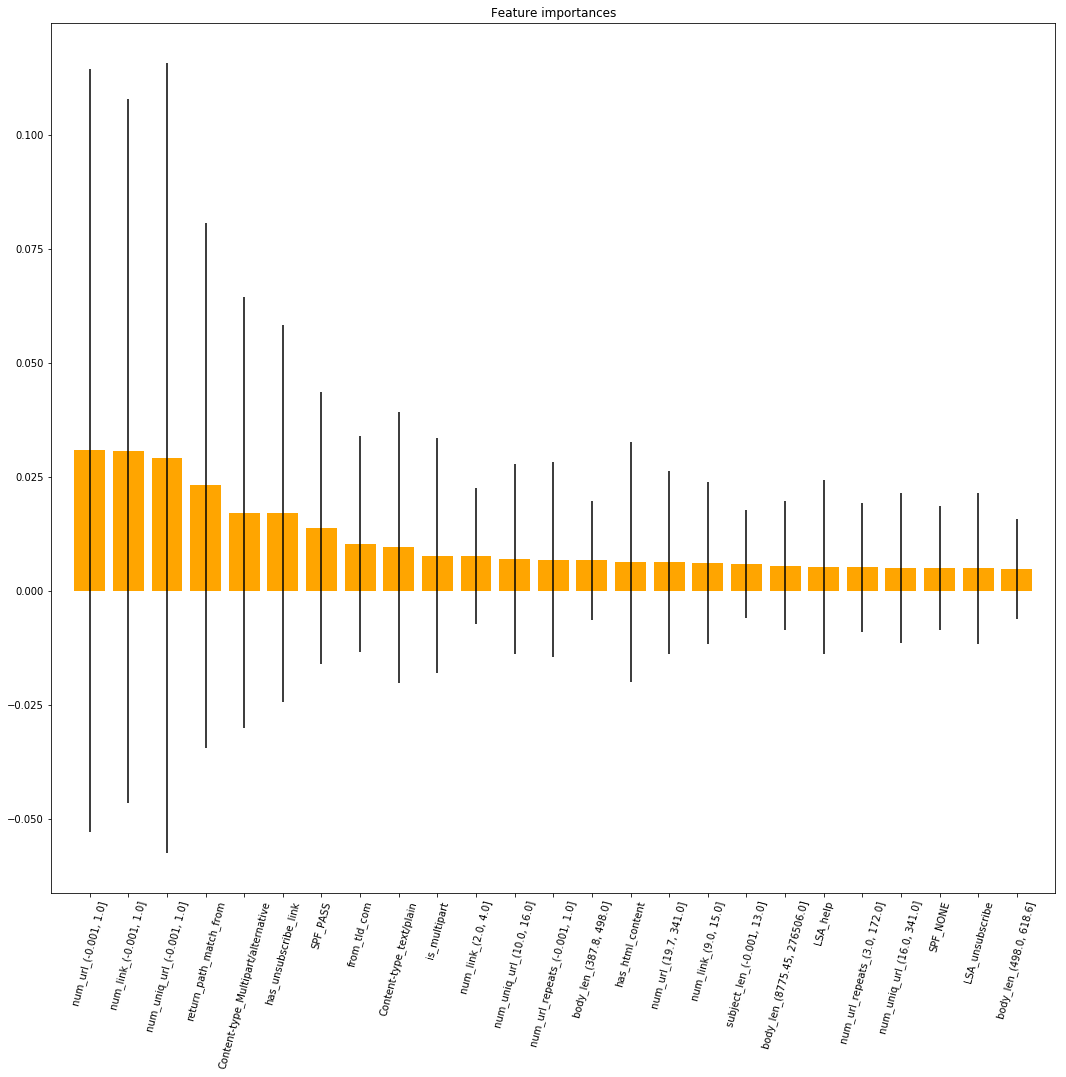

In [41]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 41.285s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 0.9974
Accuracy of data not seen: 0.9435
F1 score: 0.9275
Recall score: 0.927536
False Negatives: 5


#### XGBoost

In [43]:
# from xgboost import XGBClassifier
# t0 = time()
# xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
# xgb_clf.fit(train_feats, train_labels)
# #xgb_pred = xgb_clf.predict(test_feats)
# print("done in %0.3fs" % (time() - t0))
# score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

#### Neural Net

In [44]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 31.597s
MLPClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9379
F1 score: 0.9197
Recall score: 0.913043
False Negatives: 6


#### Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

done in 0.030s
MultinomialNB Scores:

Accuracy of data already seen: 0.9566
Accuracy of data not seen: 0.9209
F1 score: 0.9000
Recall score: 0.913043
False Negatives: 6


In [46]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.253s
GaussianNB Scores:

Accuracy of data already seen: 0.9949
Accuracy of data not seen: 0.8927
F1 score: 0.8430
Recall score: 0.739130
False Negatives: 18


#### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.840s
RandomForestClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9379
F1 score: 0.9220
Recall score: 0.942029
False Negatives: 4


In [48]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = test_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_uniq_link (0.064755)
2. return_path_match_from (0.026521)
3. num_uniq_url_(-0.001, 1.0] (0.024763)
4. num_link_(-0.001, 1.0] (0.023361)
5. num_url_(-0.001, 1.0] (0.017429)
6. Content-type_Multipart/alternative (0.012110)
7. LSA_invoice (0.011432)
8. LSA_email (0.009717)
9. LSA_unsubscribe (0.009627)
10. LSA_like (0.009315)
11. LSA_not (0.009208)
12. LSA_learn (0.008560)
13. has_unsubscribe_link (0.008201)
14. SPF_PASS (0.007159)
15. Content-type_text/plain (0.007026)
16. LSA_document (0.006806)
17. is_multipart (0.006715)
18. LSA_work (0.006444)
19. LSA_thank (0.006270)
20. LSA_time (0.005065)
21. LSA_company (0.005028)
22. LSA_future (0.004946)
23. LSA_product (0.004917)
24. LSA_twitter (0.004906)
25. has_html_content (0.004835)


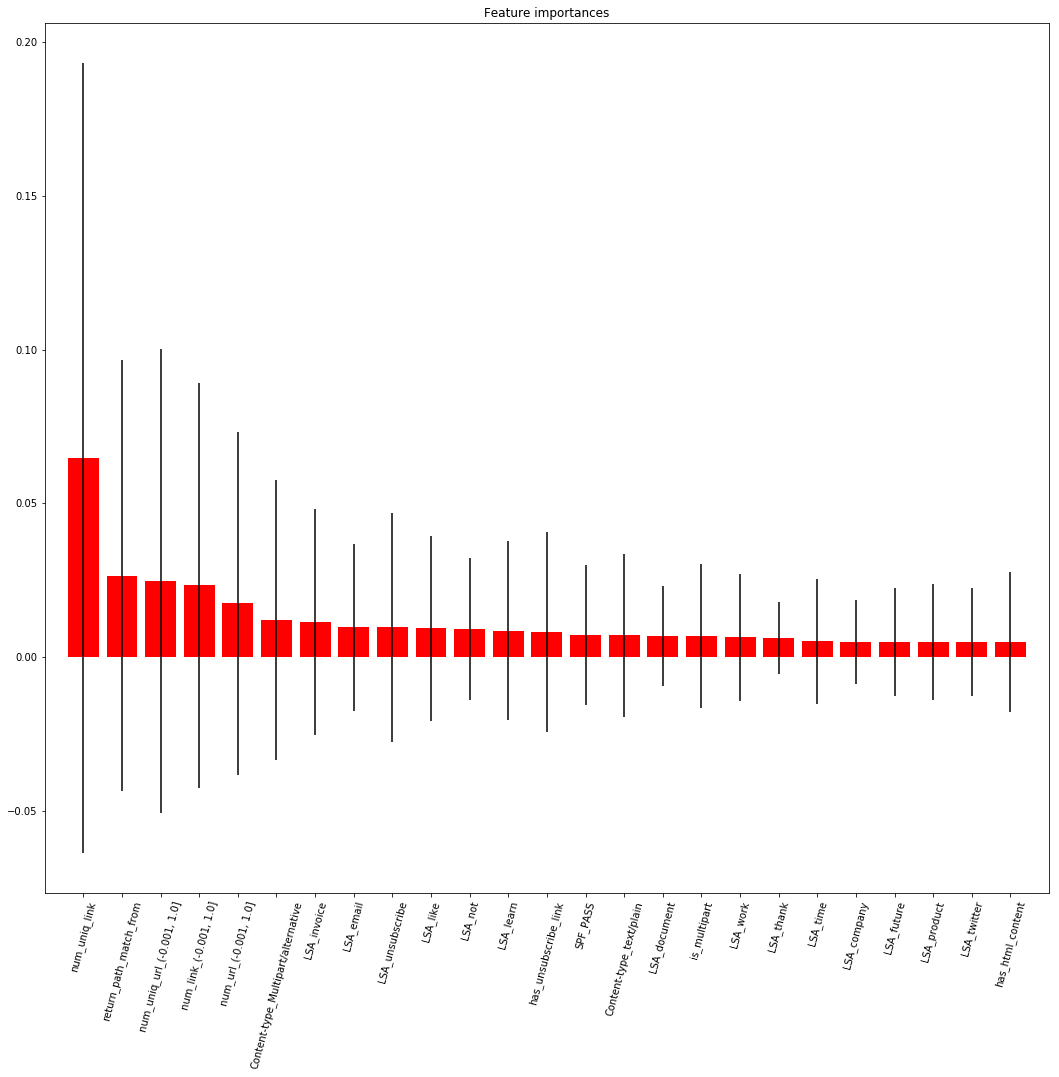

In [49]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [50]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.279s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.9120
Accuracy of data not seen: 0.8870
F1 score: 0.8611
Recall score: 0.898551
False Negatives: 7


#### NearestCentroid

In [51]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.070s
NearestCentroid Scores:

Accuracy of data already seen: 0.7334
Accuracy of data not seen: 0.7006
F1 score: 0.7166
Recall score: 0.971014
False Negatives: 2


#### AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 12.943s
AdaBoostClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9379
F1 score: 0.9209
Recall score: 0.927536
False Negatives: 5


#### QuadraticDiscriminantAnalysis

In [53]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 1.049s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.6102
F1 score: 0.0000
Recall score: 0.000000
False Negatives: 69


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### GaussianProcessClassifier

In [54]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 8.726s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.8870
F1 score: 0.8630
Recall score: 0.913043
False Negatives: 6


#### Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.534s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.8814
F1 score: 0.8591
Recall score: 0.927536
False Negatives: 5


#### LogisticRegression

In [56]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.041s
LogisticRegression Scores:

Accuracy of data already seen: 0.9707
Accuracy of data not seen: 0.9096
F1 score: 0.8857
Recall score: 0.898551
False Negatives: 7


#### PassiveAggressiveClassifier

In [57]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.154s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.9579
Accuracy of data not seen: 0.8814
F1 score: 0.8421
Recall score: 0.811594
False Negatives: 13


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [58]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.228s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9548
F1 score: 0.9429
Recall score: 0.956522
False Negatives: 3


#### SGDClassifier

In [59]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.086s
SGDClassifier Scores:

Accuracy of data already seen: 0.9069
Accuracy of data not seen: 0.8362
F1 score: 0.7852
Recall score: 0.768116
False Negatives: 16


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [60]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.306s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9266
F1 score: 0.9065
Recall score: 0.913043
False Negatives: 6


#### BaggingClassifier

In [61]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 11.296s
BaggingClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9266
F1 score: 0.9091
Recall score: 0.942029
False Negatives: 4


#### VotingClassifier

In [72]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
    #('knn',knn_clf),
#     ('nb',nb_clf),
#     ('et',et_clf),
#     ('rf',rf_clf),
    ('rd',rd_clf),
    #('bg',bg_clf),
#     ('cc',cc_clf),
    ('svm',svm_clf),
    ('gb',gb_clf),
    #('lr',lr_clf),
#     ('gnb',gnb_clf),
#     ('nn',nn_clf),
],voting='hard')
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 41.198s


In [73]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

VotingClassifier Scores:

Accuracy of data already seen: 0.9987
Accuracy of data not seen: 0.9492
F1 score: 0.9343
Recall score: 0.9275
False Negatives: 5


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [64]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

RidgeClassifier: 0.9548
GradientBoostingClassifier: 0.9435
LinearSVC: 0.9379


Best F1 Score:

RidgeClassifier: 0.9429
GradientBoostingClassifier: 0.9275
ExtraTreesClassifier: 0.9231


Best Recall Score:

SVC: 0.9710
NearestCentroid: 0.9710
ExtraTreesClassifier: 0.9565


Best False Negative Classifier:

SVC: 2
NearestCentroid: 2
ExtraTreesClassifier: 3


#### Confusion Matrix and ROC curves of Top Algos

In [65]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [66]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [67]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

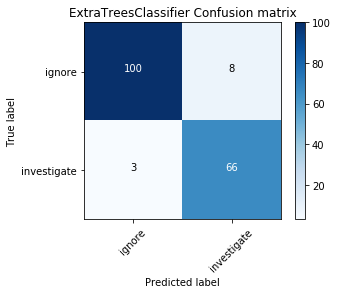

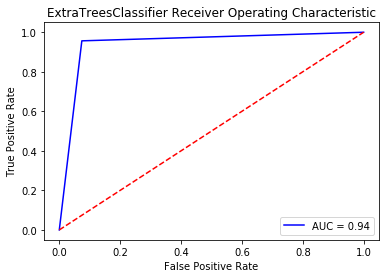

In [68]:
display_conf_mat(et_clf,test_feats,test_labels)
plot_roc_curve(et_clf,test_feats,test_labels)

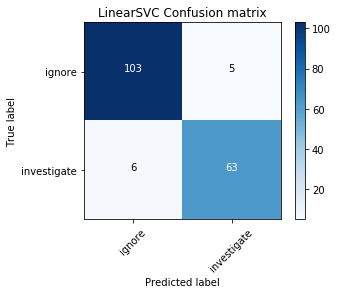

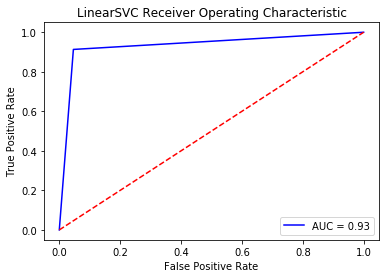

In [69]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

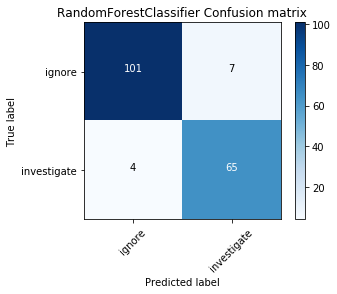

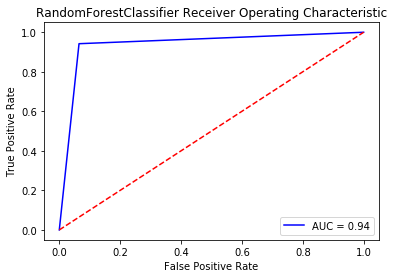

In [70]:
display_conf_mat(rf_clf,test_feats,test_labels)
plot_roc_curve(rf_clf,test_feats,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


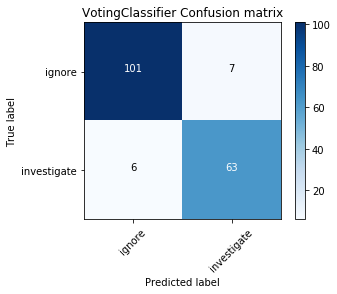

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


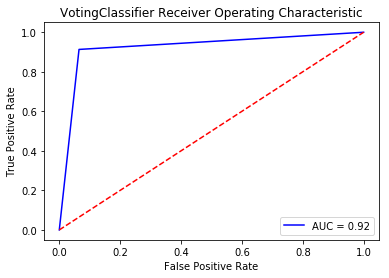

In [71]:
display_conf_mat(vt_clf,test_feats,test_labels)
plot_roc_curve(vt_clf,test_feats,test_labels)